# **Procesamiento Morfológico**

In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

## Funciones base

In [2]:
def apply_matrix(image, matrix):
    '''Cálculo del producto matricial'''
    return np.matmul(image.reshape((-1,3)), matrix.T).reshape(image.shape)

def rgb2yiq(image):
    '''Conversión del espacion RGB a YIQ'''
    rgb2yiq_matrix = np.array([[0.299,       0.587,       0.114],
                               [0.59590059, -0.27455667, -0.32134392],
                               [0.21153661, -0.52273617,  0.31119955]])
    
    if image.max() > 1:
        image = image/255.0
        print("-> Convirtiendo al espacio YIQ...")
        print("   ## Reescalando la imagen en un rango de [0, 1]")
    
    return apply_matrix(image, rgb2yiq_matrix)

def _morph_op(img, se, fcn):
    '''Implementa una operación morfológica general.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):
    '''Implementa una operación morfológica general en una imagen multicanal basada en el primer canal.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):
    '''Aplica una operación morfológica a una imagen RGB basada en el canal Y.'''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def is_size_correct(M):
    '''Confirma que el tamñao del kernel sea correcto'''
    correct = True
    error = ''
    out = np.array([], dtype=np.result_type(M, 0.0))
    if M < 1:
        correct = False
        error = '''
        >> El tamaño del filtro debe ser superior a la unidad.
           Tamaño ingresado (M): {}.
        '''
    elif M == 1:
        correct = False
        error = '''
        >> El tamaño del filtro es igual a la unidad.
        '''
        out = np.ones(1, dtype=np.result_type(M, 0.0))
    elif (M % 2) == 0:
        correct = False
        error = '''
        >> El tamaño del filtro debe ser IMPAR.
           Tamaño ingresado (M): {}.
        '''
    return correct, error.format(M), out

def plot2(image1, image2, titles=[]):
    fig, axes = plt.subplots(1, 2, figsize=(15,15))
    axes[0].imshow(image1, 'gray')
    axes[1].imshow(image2, 'gray')
    
    if titles:
        axes[0].set_title(titles[0])
        axes[1].set_title(titles[1])
        
    plt.show()

def plot3(image1, image2, image3, titles=[]):
    fig, axes = plt.subplots(1, 3, figsize=(15,10))
    axes[0].imshow(image1, 'gray')
    axes[1].imshow(image2, 'gray')
    axes[2].imshow(image3, 'gray')
    
    if titles:
        axes[0].set_title(titles[0])
        axes[1].set_title(titles[1])
        axes[2].set_title(titles[2])
    
    plt.show()

## Imagen de prueba

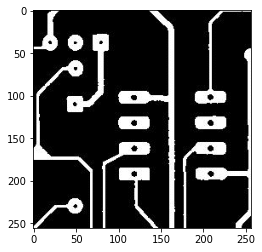

In [3]:
path = 'docs/pcb_traces.jpg'
img_gray = imageio.imread(path)/255

plt.imshow(img_gray, 'gray')
plt.show()

## **1. Elementos estructurantes (SE)**

### **1.1. Cuadrado (Box)**

In [4]:
def BOX(M):
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    return np.ones((M, M), bool)

### **1.2. Disco (Disk/Circle)**

In [5]:
def DISK(M):
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    kernel = np.zeros((M, M))
    radius = (M - 1) / 2
    L = np.arange(-radius, radius + 1)
    X, Y = np.meshgrid(L, L)
    mask = np.array((X ** 2 + Y ** 2) <= radius ** 2)
    kernel[mask] = 1
    
    return kernel.astype(bool)

## **2. Operaciones básicas (nivel 1)**

### **2.1. Erosión**

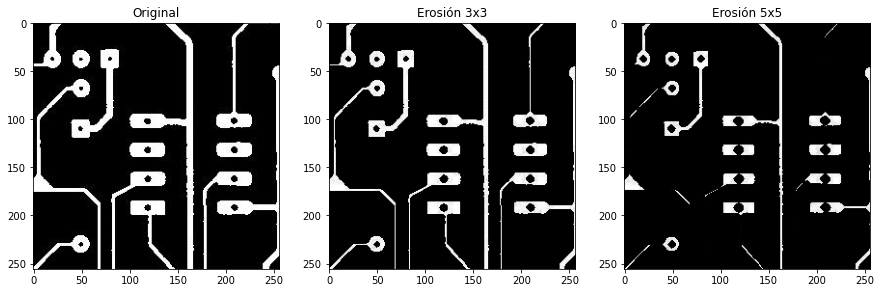

In [6]:
def img_erosion(img, se):
    '''Erosión morfológica para imágenes binarias, en escala de grises o RGB.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)

img_eroded3 = img_erosion(img_gray, DISK(3))
img_eroded5 = img_erosion(img_gray, DISK(5))

plot3(img_gray, img_eroded3, img_eroded5, ['Original', 'Erosión 3x3', 'Erosión 5x5'])

### **2.2. Dilatación**

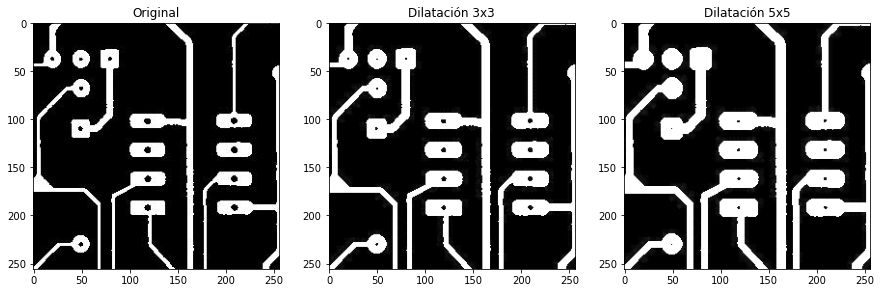

In [7]:
def img_dilation(img, se):
    '''Dilatación morfológica para imágenes binarias, en escala de grises o RGB.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

img_dilated3 = img_dilation(img_gray, DISK(3))
img_dilated5 = img_dilation(img_gray, DISK(5))

plot3(img_gray, img_dilated3, img_dilated5, ['Original', 'Dilatación 3x3', 'Dilatación 5x5'])

### **2.3. Filtro de mediana**

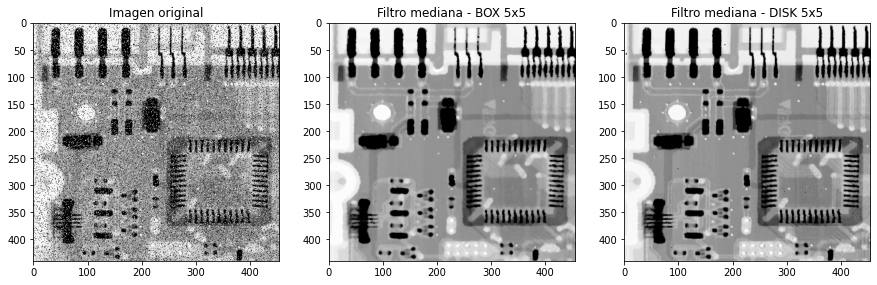

In [8]:
def argmedian(x):
    '''Devuleve el índice/posición de la mediana de un array'''
    x = x.flatten() if x.ndim > 1 else x
    return np.argpartition(x, len(x) // 2)[len(x) // 2]

def img_median(img, se):
    '''Filtro mediana para imágenes binarias, en escala de grises o RGB.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.median)
    else:
        return _morph_color(img, se, argmedian)

img_noisy = imageio.imread('docs/noisy_img.png')/255
plot3(img_noisy, img_median(img_noisy, BOX(5)), img_median(img_noisy, DISK(5)), 
      titles=['Imagen original', 'Filtro mediana - BOX 5x5', 'Filtro mediana - DISK 5x5'])

## **3. Suma y resta entre erosión y dilatación.**

**3.1. Borde externo:** Imagen dilatada menos imagen original.

**3.2. Borde interno:** Imagen original menos imagen erosionada.

**3.3. Gradiente:** Imagen dilatada menos imagen erosionada.

In [9]:
def outer_border(image, se):
    '''Borde externo para imágenes binarias, en escala de grises o RGB.'''
    img_dilated = img_dilation(image, se)
    return img_dilated - image

def inner_border(image, se):
    '''Borde interno para imágenes binarias, en escala de grises o RGB.'''
    img_eroded = img_erosion(image, se)
    return image - img_eroded

def gradient(image, se):
    '''Gradiente para imágenes binarias, en escala de grises o RGB.'''
    img_dilated = img_dilation(image, se)
    img_eroded = img_erosion(image, se)
    return img_dilated - img_eroded

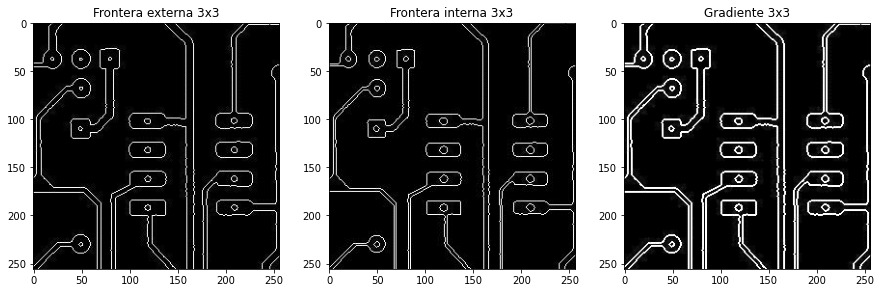

In [10]:
# Elemento estructurante de tamaño 3x3
se = DISK(3)
img_outer = outer_border(img_gray, se)
img_inner = inner_border(img_gray, se)
img_gradient = gradient(img_gray, se)
plot3(img_outer, img_inner, img_gradient, ['Frontera externa 3x3', 'Frontera interna 3x3', 'Gradiente 3x3'])

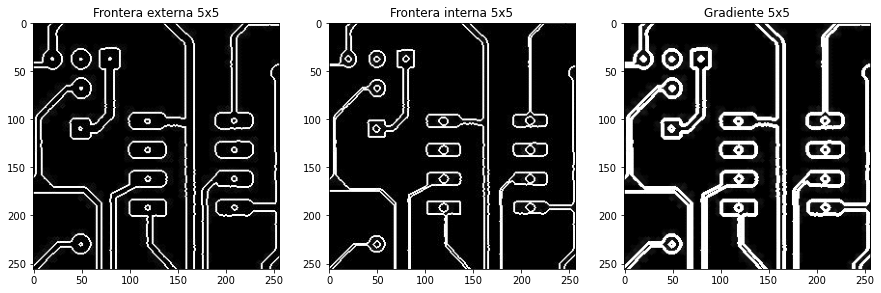

In [11]:
# Elemento estructurante de tamaño 5x5
se = DISK(5)
img_outer = outer_border(img_gray, se)
img_inner = inner_border(img_gray, se)
img_gradient = gradient(img_gray, se)
plot3(img_outer, img_inner, img_gradient, ['Frontera externa 5x5', 'Frontera interna 5x5', 'Gradiente 5x5'])

## **4. Dilatación y erosión concatenadas (nivel 2)**


**4.1. Apertura (opening):** Imagen erosionada y luego dilatada.

**4.2. Cierre (closing):** Imagen dilatada y luego erosionada.

**4.3. Top-hat (White top hat):** Imagen original menos su apertura.

**4.4. Bottom-hat (Black top hat):** Cierre morfológico menos la imagen original.

In [12]:
def opening(image, se):
    '''Abre los espacios oscuros ubicados entre elementos brillantes'''
    img_eroded = img_erosion(image, se)
    return img_dilation(img_eroded, se)

def closing(image, se):
    '''Cierra pequeños espacios oscuros ubicados entre elementos brillantes'''
    img_dilated = img_dilation(image, se)
    return img_erosion(img_dilated, se)

def top_hat(image, se):
    '''Retorna los elementos brillantes de la imagen que sean más pequeños 
       que el elemento estructurante (SE)'''
    img_opened = opening(image, se)
    return image - img_opened

def bottom_hat(image, se):
    '''Retorna los elementos oscuros de la imagen que sean más pequeños 
       que el elemento estructurante (SE)'''
    img_closed = closing(image, se)
    return img_closed - image

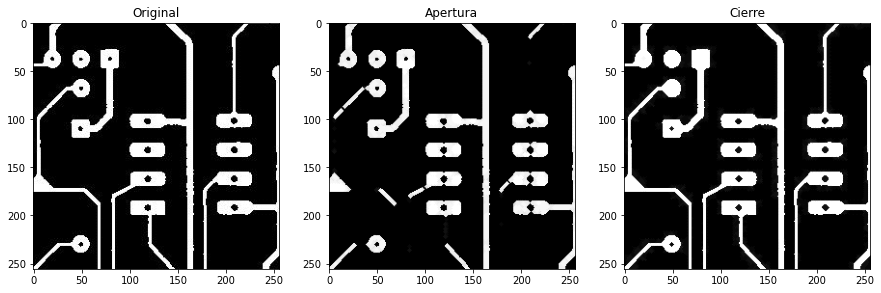

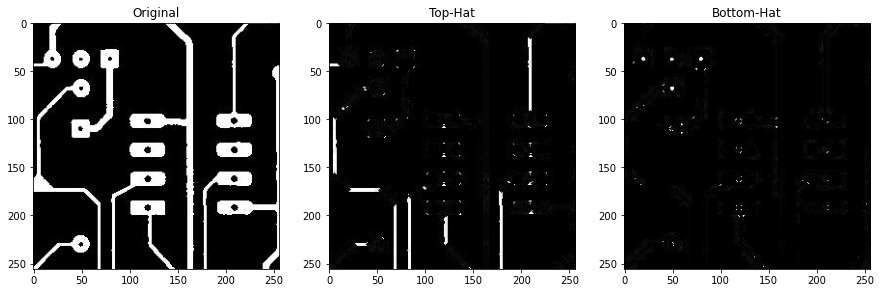

In [13]:
se = DISK(5)
img_opened = opening(img_gray, se)
img_closed = closing(img_gray, se)
img_topHat = top_hat(img_gray, se)
img_bottomHat = bottom_hat(img_gray, se)

plot3(img_gray, img_opened, img_closed, ['Original', 'Apertura', 'Cierre'])
plot3(img_gray, img_topHat, img_bottomHat, ['Original', 'Top-Hat', 'Bottom-Hat'])

## **5. Cierre y apertura concatenadas (nivel 3)**

In [14]:
def opening_closing(image, se):
    '''Apertura seguido de un cierre.'''
    img_opened = opening(image, se)
    return closing(img_opened, se)

def closing_opening(image, se):
    '''Cierre seguido de una apertura.'''
    img_closed = closing(image, se)
    return opening(img_closed, se)

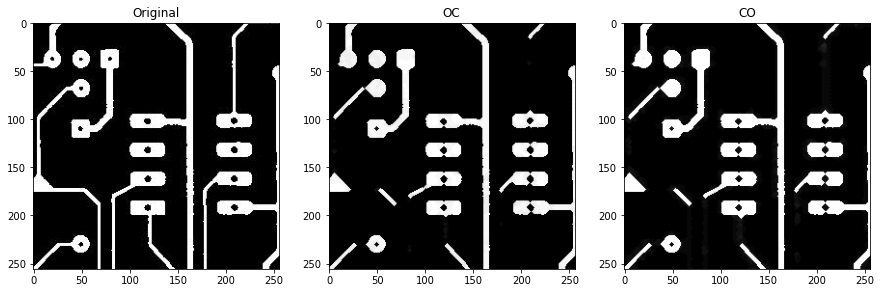

In [15]:
se = DISK(5)
img_OC = opening_closing(img_gray, se)
img_CO = closing_opening(img_gray, se)

plot3(img_gray, img_OC, img_CO, ['Original', 'OC', 'CO'])

## **6. Funciones con operaciones morfológicas**

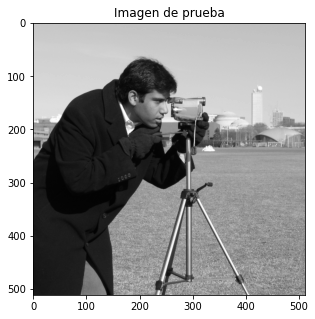

In [16]:
img_camera = imageio.imread('imageio:camera.png')/255

fig = plt.figure(figsize=(5, 5))
plt.title('Imagen de prueba')
plt.imshow(img_camera, 'gray')
plt.show()

### **6.1. Suavizado (Smoothing)**

Promedio entre operaciones morfológicas del mismo 'nivel'. 

* **Nivel 1:** (dilatación + erosión)/2
* **Nivel 2:** (apertura + cierre)/2
* **Nivel 3:** (OC + CO)/2

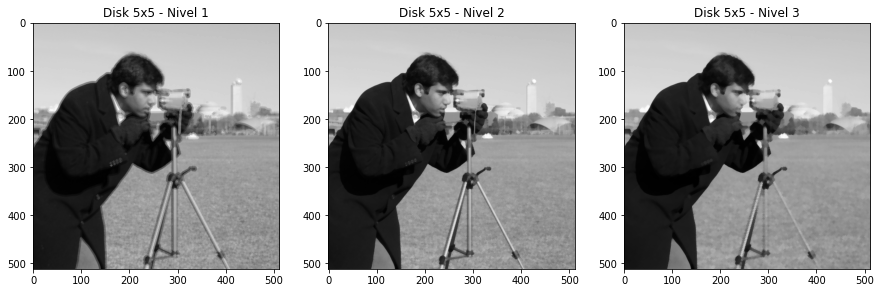

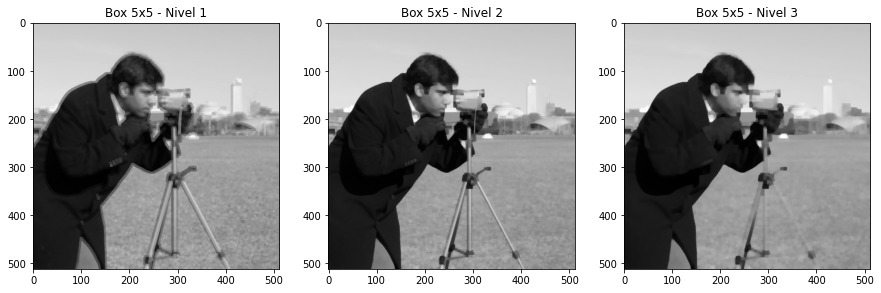

In [17]:
def smoothing_morph(image, se, level=1):
    '''Suavizado no lineal a partir de operaciones morfológicas'''
    if level == 1:
        img_operation1 = img_dilation(image, se)
        img_operation2 = img_erosion(image, se)
    elif level == 2:
        img_operation1 = opening(image, se)
        img_operation2 = closing(image, se)
    elif level == 3:
        img_operation1 = opening_closing(image, se)
        img_operation2 = closing_opening(image, se)
    else:
        print("'level' debe ser un Int en el rango [1, 3].")
        return np.array([])
    
    return (img_operation1 + img_operation2) / 2

# Prueba con un elemeno estructurante (SE) de tamaño 5
size = 5
se_box = BOX(size)
se_disk = DISK(size)

plot3(smoothing_morph(img_camera, se_disk, 1), 
      smoothing_morph(img_camera, se_disk, 2), 
      smoothing_morph(img_camera, se_disk, 3),
      titles=[f'Disk {size}x{size} - Nivel 1', f'Disk {size}x{size} - Nivel 2', f'Disk {size}x{size} - Nivel 3'])

plot3(smoothing_morph(img_camera, se_box, 1), 
      smoothing_morph(img_camera, se_box, 2), 
      smoothing_morph(img_camera, se_box, 3),
      titles=[f'Box {size}x{size} - Nivel 1', f'Box {size}x{size} - Nivel 2', f'Box {size}x{size} - Nivel 3'])

### **6.2. Realce de contraste (edge enhance)**

Adición de una fracción (`weight`) de las frecuencias altas a la imagen original. Estas frecuencias se obtienen a partir de la diferencia entre la imagen original y la suavizada (calculada con la función anterior `smoothing_morph`).

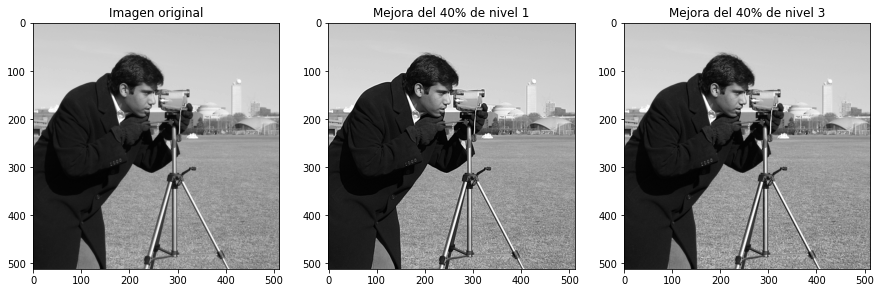

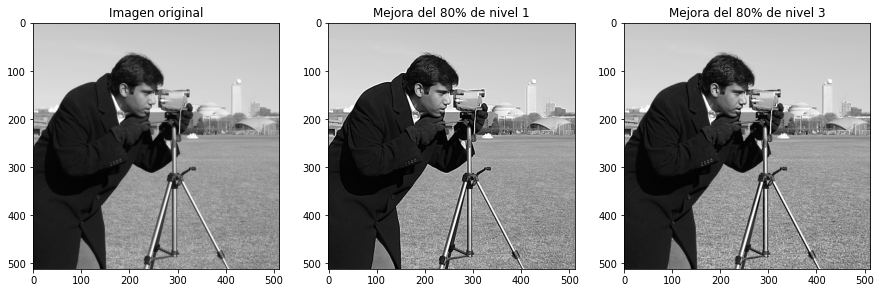

In [18]:
def edge_enhance(image, se, weight, level=1):
    '''Mejora de contraste mediante operaciones morfológicas'''
    img_smoothed = smoothing_morph(image, se, level)
    return np.clip(image + (weight * (image - img_smoothed)), 0, 1)

# Prueba con un SE de forma Disco de 5x5 y contribución del 40% y 80%
plot3(img_camera, 
      edge_enhance(img_camera, DISK(5), weight=0.4, level=1), 
      edge_enhance(img_camera, DISK(5), weight=0.4, level=3), 
      titles=['Imagen original', 'Mejora del 40% de nivel 1', 'Mejora del 40% de nivel 3'])

plot3(img_camera, 
      edge_enhance(img_camera, DISK(5), weight=0.8, level=1), 
      edge_enhance(img_camera, DISK(5), weight=0.8, level=3), 
      titles=['Imagen original', 'Mejora del 80% de nivel 1', 'Mejora del 80% de nivel 3'])

## **7. Aplicaciones**

### **7.1. Extracción de texto**

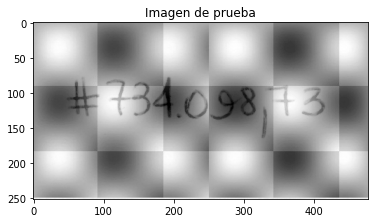

In [19]:
text_path = 'docs/text.png'
img_text = imageio.imread(text_path)/255

plt.imshow(img_text, 'gray')
plt.title('Imagen de prueba')
plt.show()

* El objetivo es, tomar la imagen de prueba mostrada en la celda anterior y procesarla de manera que la imagen resultante muestre únicamente el texto: `#734.098,73`.


* Como bien se observa, los caracteres tienden a ser más oscuros respecto al resto de la imagen. Por lo anterior, se implementa la transformación **`Bottom-hat`** (también conocida como **`Black top-hat`**) ya que esta devuelve aquellos elementos de la imagen que sean más oscuros respecto a su alrededor y más pequeños que el elemento estructurante (`SE`)


* La transformación se prueba con dos elementos estructurantes de diferente tamaño y forma.

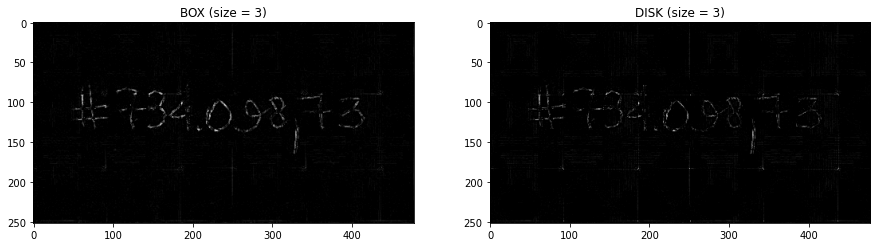

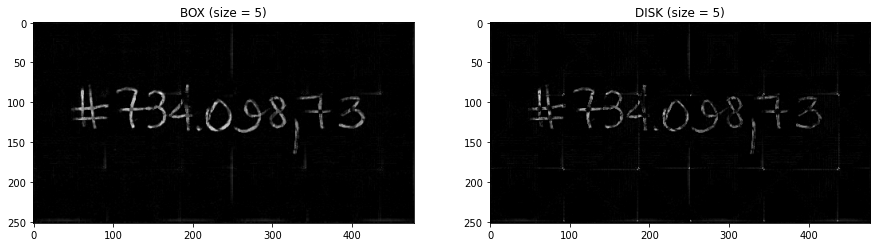

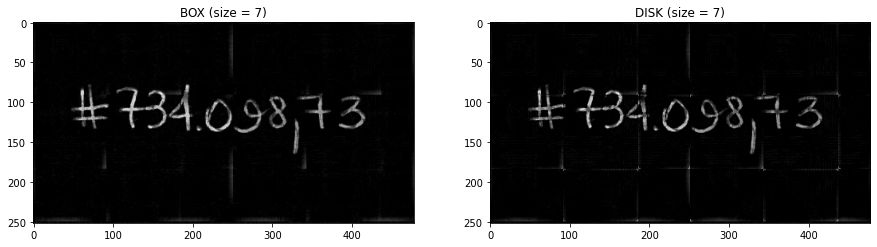

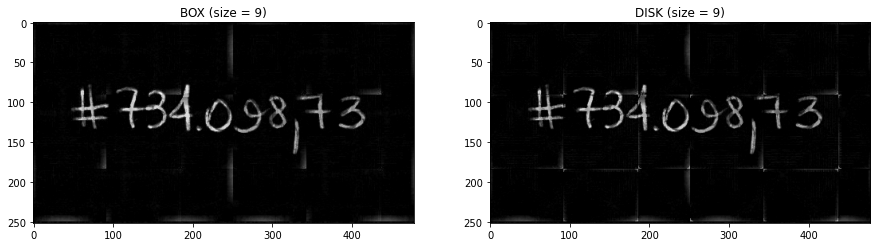

In [20]:
# Tamaños a probar del elemento estructurante
se_sizes = [3, 5, 7, 9]

for se_size in se_sizes:
    plot2(bottom_hat(img_text, BOX(se_size)), bottom_hat(img_text, DISK(se_size)),
         titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* Se observa que para el SE de forma **`DISK`**, los contornos de las cuadriculas resaltan con mayor facilidad a comparación del elemento de forma **`BOX`**


* También se muestra que para tamaños superiores e iguales a **`7x7`** del SE, se detallan en su mayoría el texto objetivo.


* Con lo anterior, se aplica una binarización de las imágenes para descartar los niveles de luminancia intermedios.

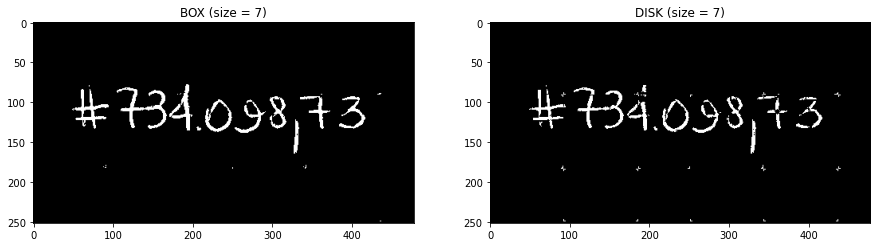

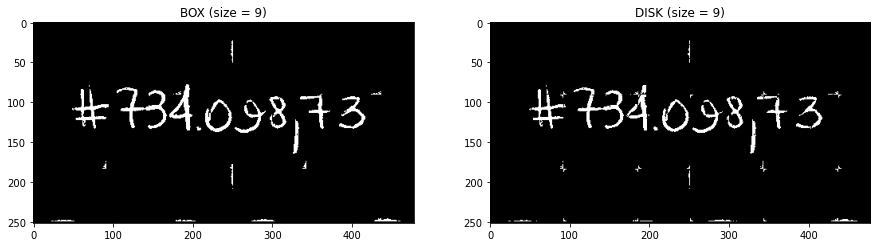

In [21]:
# Tamaños a probar del elemento estructurante
se_sizes = [7, 9]
umbral = 0.07

for se_size in se_sizes:
    out_box = (bottom_hat(img_text, BOX(se_size)) > umbral).astype('uint8')
    out_disk = (bottom_hat(img_text, DISK(se_size)) > umbral).astype('uint8')
    plot2(out_box, out_disk, titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* Finalmente se observa que para un **SE de forma BOX de 7x7 y un umbral de binarización de 0.07**, se obtiene una imagen con la menor cantidad de elementos indeseados (según el umbral elegido).

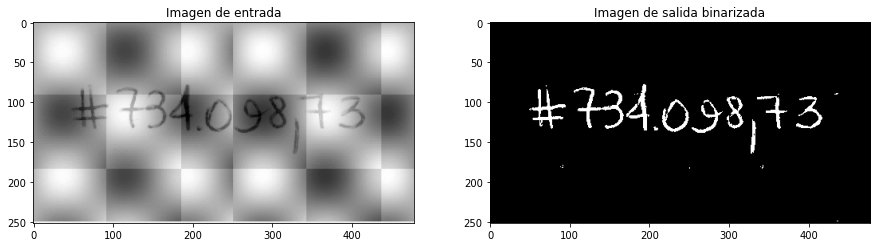

In [22]:
img_text_processed = bottom_hat(img_text, BOX(7))
umbral = 0.07
out = (img_text_processed > umbral).astype('uint8')

plot2(img_text, out, ['Imagen de entrada', 'Imagen de salida binarizada'])

### **7.2. Eliminación de texto**

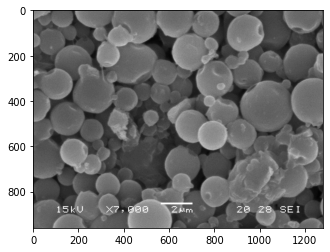

In [23]:
particles_path = 'docs/particles.png'
img_particles = imageio.imread(particles_path)/255

plt.imshow(img_particles, 'gray')
plt.show()

* La idea es tomar la imagen de prueba mostrada en la celda anterior y procesarla de manera que la imagen resultante suprima el texto de color blanco ubicado en la parte inferior.


* Como bien se observa, los caracteres tienden a ser más claros respecto al resto de la imagen. Por lo anterior, se implementa la transformación **`Top-hat`** (también conocida como **`White top-hat`**) ya que esta devuelve aquellos elementos de la imagen que sean más claros respecto a su alrededor y más pequeños que el elemento estructurante (`SE`)


* Nuevamente, se prueba este tipo de transformación con dos elementos estructurantes de diferente tamaño y forma.

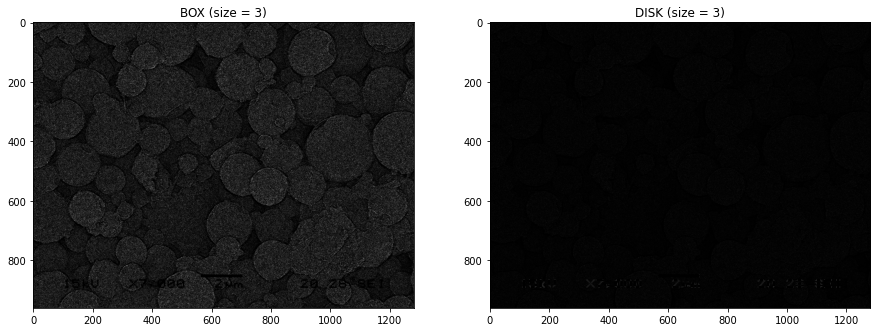

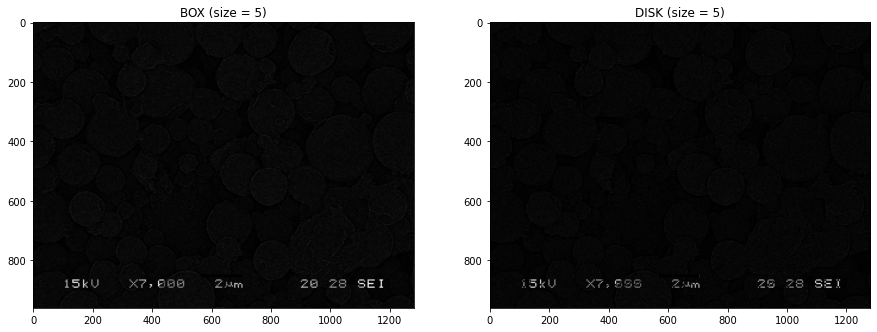

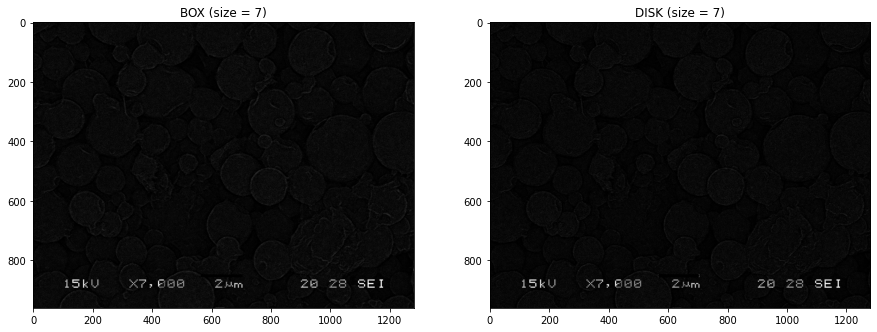

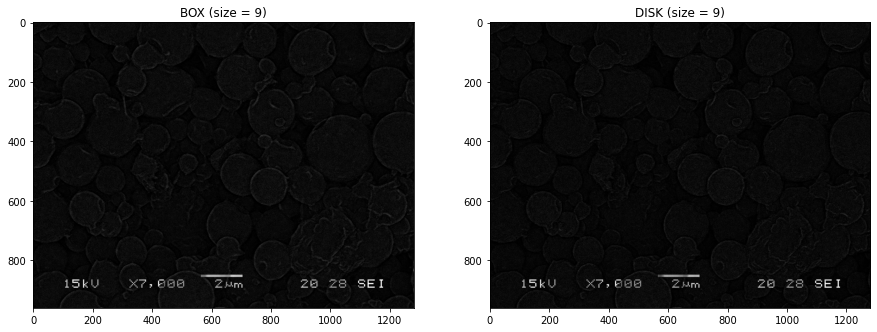

In [24]:
# Tamaños a probar del elemento estructurante
se_sizes = [3, 5, 7, 9]

for se_size in se_sizes:
    plot2(top_hat(img_particles, BOX(se_size)), top_hat(img_particles, DISK(se_size)),
         titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* Primero, se observa que con el SE de tamaño 3 no se alcanza a detectar el texto. Esto se debe a que el SE llega a ser más pequeño que el propio grosor de las letras.


* Dando continuidad a lo anterior, los SE de tamaño 5 y 7 no logran detectar la line horizontal situada encima del texto $2\mu m$.


* Por esto, se procede a binarizar la imagen con los SE de tamaño 9.

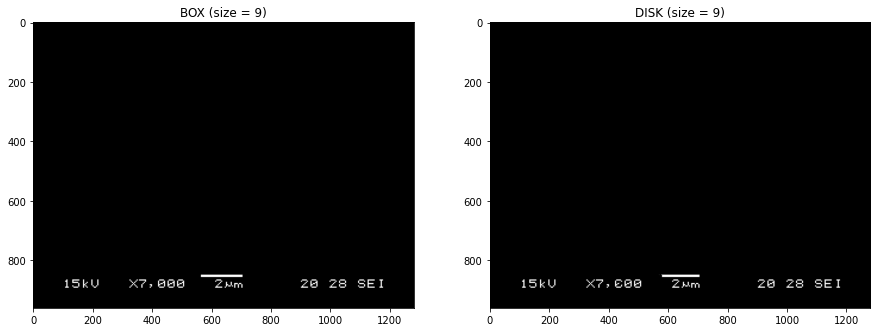

In [25]:
umbral = 0.35

out_box = (top_hat(img_particles, BOX(9)) > umbral).astype('uint8')
out_disk = (top_hat(img_particles, DISK(9)) > umbral).astype('uint8')
plot2(out_box, out_disk, titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* Ambas imágenes presentan resultados muy similares, sin embargo el SE de forma BOX describe por completo los dígitos del texto $X7,000$.

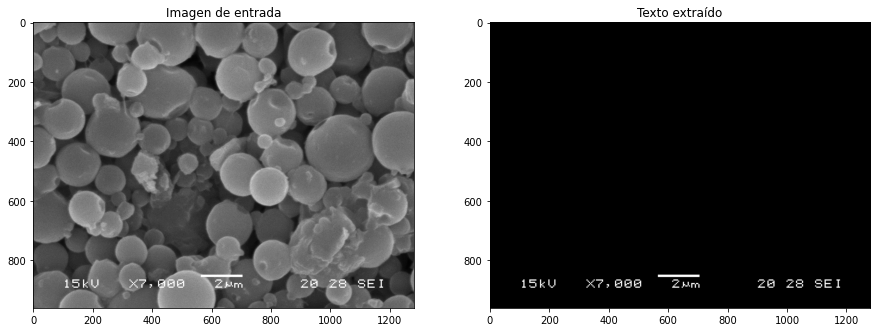

In [26]:
plot2(img_particles, out_box, ['Imagen de entrada', 'Texto extraído'])

* Obtenido los píxeles donde se ubica el texto a eliminar, se busca una operación que permita 'borrar' el mismo (por completo) de la imagen original. Con esto, se aplica un **`opening`** ya que permite abrir los píxeles oscuros (contorno) ubicados entre elementos brillantes (texto).


* Se inicia usando un SE de tamaño 9 ya que, como se vio en las pruebas previas, los SE con tamaño inferior a 9 no logran detectar todos los elementos que componen el texto objetivo.

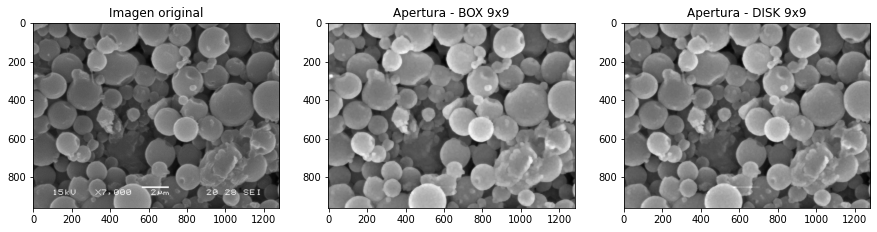

In [27]:
img_particles_opened1 = opening(img_particles, BOX(9))
img_particles_opened2 = opening(img_particles, DISK(9))

plot3(img_particles, img_particles_opened1, img_particles_opened2, 
      titles=['Imagen original', 'Apertura - BOX 9x9', 'Apertura - DISK 9x9'])

* Obsérvese que el SE de forma BOX logra abrir de mejor manera la barra horizontal que se encuentra sobre el texto: $2\mu m$


* Finalmente, se aplica la apertura previa UNCAMENTE a los píxeles donde se encuentra el texto. Para esto se crea una máscara con las posiciones del texto usando la imagen binarizada resultado de la transformación Top-Hat.

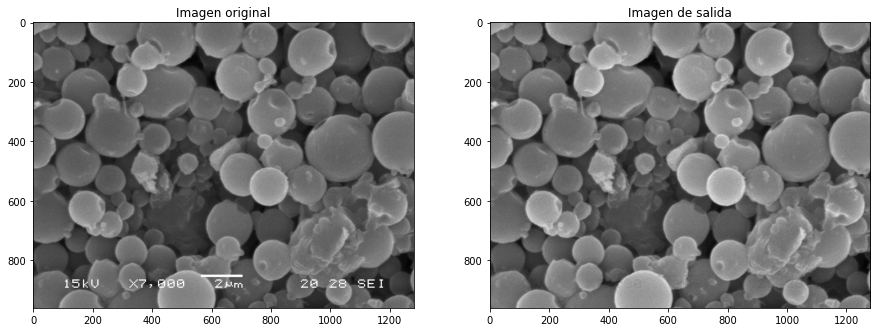

In [28]:
text_mask = out_box.astype(bool)

img_particles_out = img_particles.copy()
img_particles_out[text_mask] = img_particles_opened1[text_mask]

plot2(img_particles, np.clip(img_particles_out, 0, 1), titles=['Imagen original', 'Imagen de salida'])

### **7.3. Segmentación de la retina**

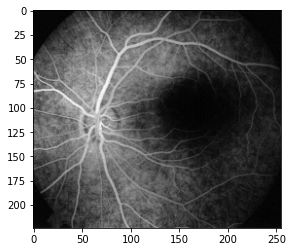

In [29]:
retina_path = 'docs/retina.bmp'
img_retina = imageio.imread(retina_path)/255

plt.imshow(img_retina, 'gray')
plt.show()

* La imagen anterior ilustra la retina del ojo humano y, a partir de ella, se busca obtener una imagen donde se muestren solo los nervios del mismo.


* Tal como se ha visto en el caso de **`7.2. Eliminación de texto`**, los nervios se destacan por ser, mayormente, más claros que el resto de la imagen; por lo cual, la aplicación de una transformación de tipo **`Top-Hat`** permitirá resaltar los elementos con las características mencionadas.

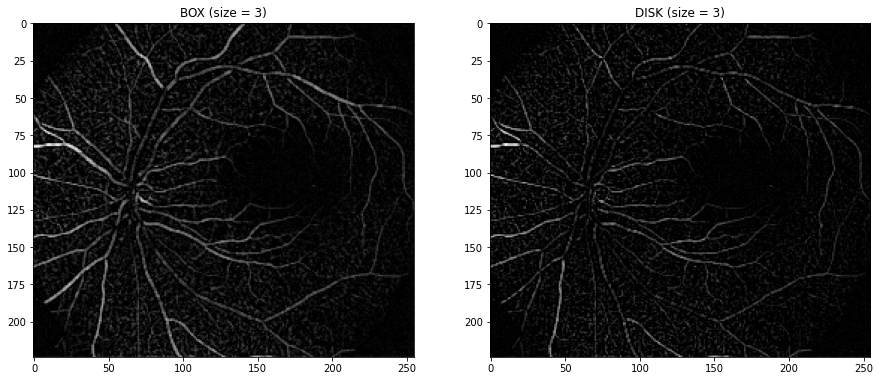

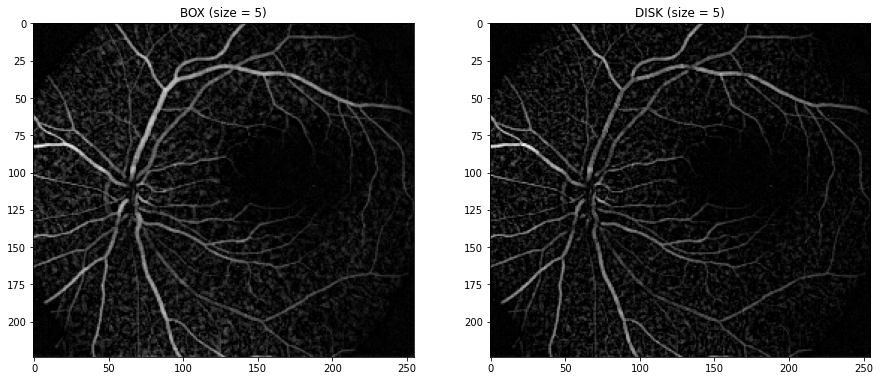

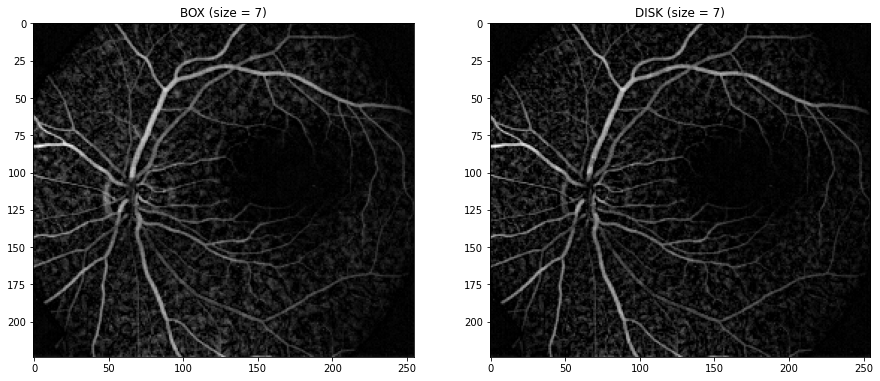

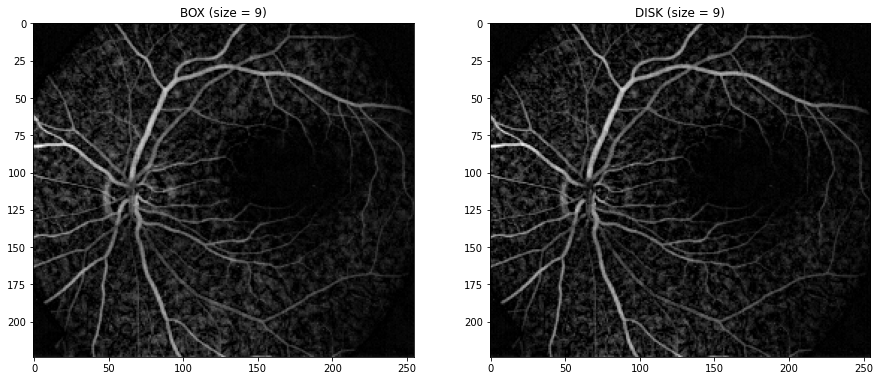

In [30]:
# Tamaños a probar del elemento estructurante
se_sizes = [3, 5, 7, 9]

for se_size in se_sizes:
    plot2(top_hat(img_retina, BOX(se_size)), top_hat(img_retina, DISK(se_size)),
         titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* Ahora, se verifica el resultado de la binarización de estas imágenes

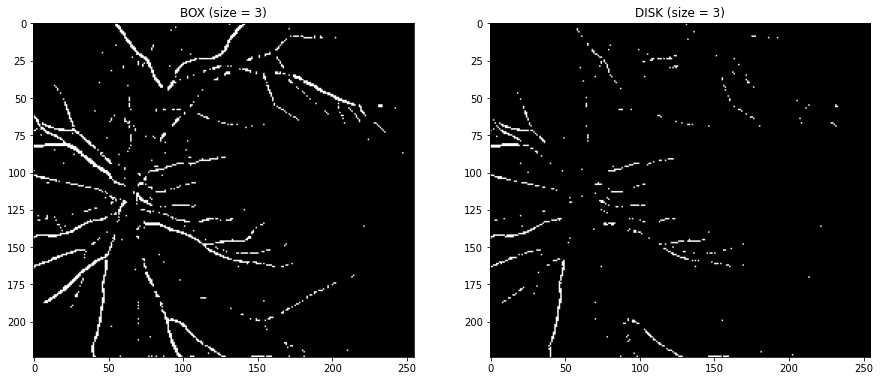

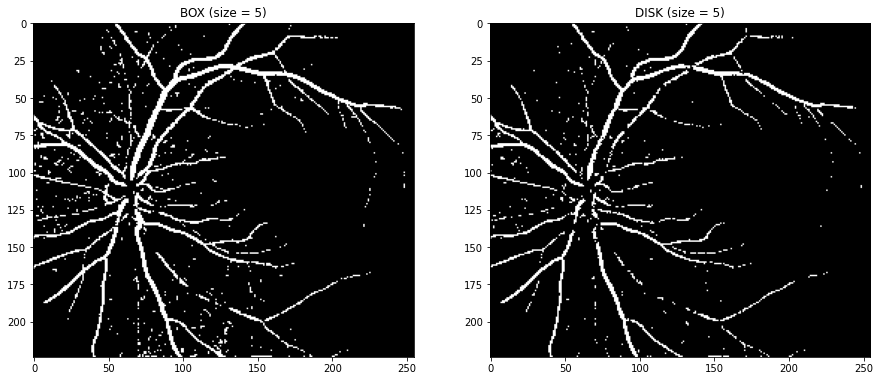

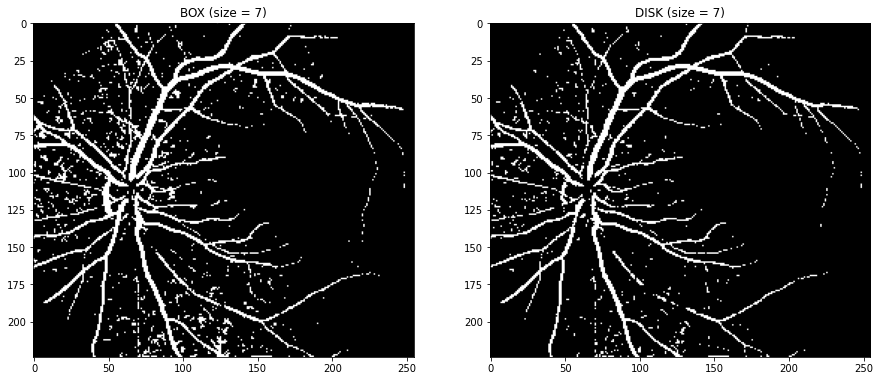

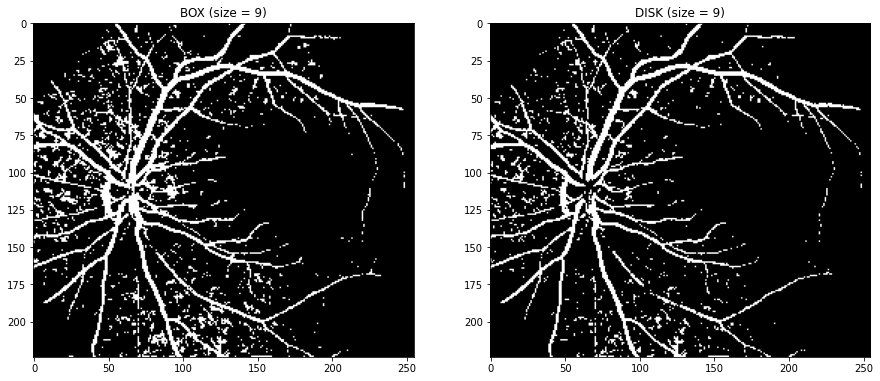

In [31]:
# Tamaños a probar del elemento estructurante
se_sizes = [3, 5, 7, 9]
umbral = 0.07

for se_size in se_sizes:
    out_box = (top_hat(img_retina, BOX(se_size)) > umbral).astype('uint8')
    out_disk = (top_hat(img_retina, DISK(se_size)) > umbral).astype('uint8')
    plot2(out_box, out_disk, titles=['BOX (size = {})'.format(se_size), 'DISK (size = {})'.format(se_size)])

* A partir de pruebas variando el umbral, se elige uno de *0.07*. Para este valor, se observa que las imágenes con un elemento estructurante de tamaño inferior a 7, omite algunos segmentos de nervios (respecto a los otros SE de mayor tamaño)


* En principio el **SE de tamaño 7 y de forma BOX** es el que *'mejor'* corresponde, ya que resalta los nervios con menor cantidad de elementos indeseados. Sin embargo, el verdadero criterio de elección y procesamiento adicional dependerá de una aplicación práctica.

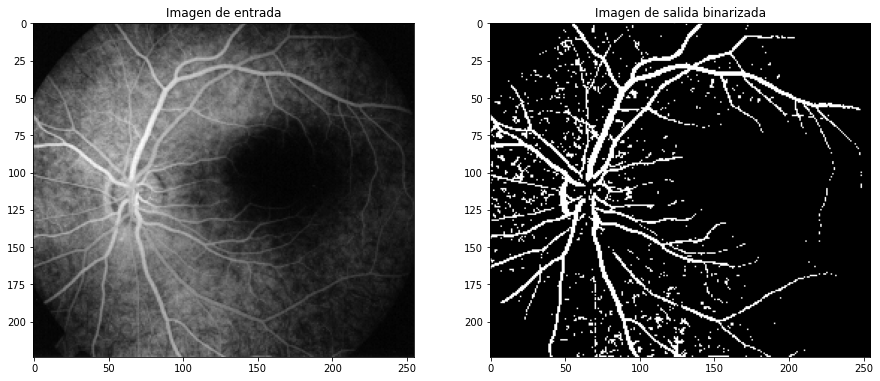

In [32]:
img_retina_processed = top_hat(img_retina, BOX(7))
umbral = 0.07
out = (img_retina_processed > umbral).astype('uint8')

plot2(img_retina, out, ['Imagen de entrada', 'Imagen de salida binarizada'])

## Links de interés

* [Filtros con operaciones morfológicas | Skimage](https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html)